In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from dataset_prep import prepare_data
from matplotlib import pyplot as plt

In [83]:
data = pd.read_csv('statcast_data_2016_2023.csv')
data = data.dropna(subset=["events"])

# Calculate handedness of batters. If a batter only bats from one side, we can use that to determine their handedness.
handedness_map = {}
for batter in data["batter"].unique():
    batter_df = data[["batter", "stand"]][data["batter"] == batter]
    stand_counts = batter_df["stand"].value_counts()
    if len(stand_counts) == 1:
        handedness_map[batter] = stand_counts.index[0]
    else:
        # If a batter bats from both sides, count them as a switch hitter if they have at least 25 at-bats from each side.
        handedness_map[batter] = "S" if stand_counts.min() >= 25 else stand_counts.index[0]

# Preprocess the events data
events_to_keep = data["events"].value_counts().iloc[:20].index.tolist()
events_to_drop = ["force_out", "caught_stealing_2b", "catcher_interf", "other_out", "pickoff_2b", "caught_stealing_home", "pickoff_1b", "sac_fly_double_play",
                  "caught_stealing_3b", "wild_pitch"]
events_to_keep = [x for x in events_to_keep if x not in events_to_drop]

event_map = {"field_error": "field_out", "grounded_into_double_play": "field_out", "fielders_choice_out": "field_out",
             "fielders_choice": "field_out", "strikeout_double_play": "strikeout", "double_play": "field_out",}
data["events"] = data["events"].replace(event_map)
data = data[data["events"].isin(events_to_keep)]

# Include hit location in the event
data["events"] = data["events"].astype(str) + "-" + data["hit_location"].astype(str)

df = data[["batter", "pitcher", "events"]]
df = df.dropna()

/var/folders/6_/_y8v0gjj4sz2yhr732yn3_tc0000gn/T/ipykernel_27552/374172231.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('statcast_data_2016_2023.csv')


In [85]:
# Only keep the most common batters and pitchers
batter_counts = df['batter'].value_counts()
pitcher_counts = df['pitcher'].value_counts()
event_counts = df['events'].value_counts()

batters_to_keep = list(batter_counts.index)[:300]
pitchers_to_keep = list(pitcher_counts.index)[:250]

df = df[df['batter'].isin(batters_to_keep) & df['pitcher'].isin(pitchers_to_keep)]

In [86]:
new_batter_counts = df['batter'].value_counts()
new_pitcher_counts = df['pitcher'].value_counts()


print(new_batter_counts.min(), new_batter_counts.max())
print(new_pitcher_counts.min(), new_pitcher_counts.max())

705 2683
918 3545


In [87]:
NUM_BATTERS = df['batter'].nunique()
NUM_PITCHERS = df['pitcher'].nunique()
NUM_EVENTS = df['events'].nunique()

VEC_SIZE = 128
# BATCH_SIZE = len(df) #min(2048, len(df))
NUM_EPOCHS = 50
learning_rate = 0.001
# activation = nn.ReLU()
activation = nn.Sigmoid()

In [88]:
class BaseballDataset(Dataset):
    def __init__(self, dataframe):
        self.batter = torch.tensor(dataframe['batter_codes'].values, dtype=torch.long)
        self.pitcher = torch.tensor(dataframe['pitcher_codes'].values, dtype=torch.long)
        self.event = torch.tensor(dataframe['event_codes'].values, dtype=torch.long)

    def __len__(self):
        return len(self.batter)

    def __getitem__(self, idx):
        return self.batter[idx], self.pitcher[idx], self.event[idx]

# Model definition
class BaseballModel(nn.Module):
    def __init__(self, num_batters, num_pitchers, vec_size, num_outcomes):
        super(BaseballModel, self).__init__()
        self.batter_embedding = nn.Embedding(num_batters, vec_size)
        self.pitcher_embedding = nn.Embedding(num_pitchers, vec_size)
        self.fc = nn.Linear(2*vec_size, num_outcomes)
    
    def forward(self, batter_idx, pitcher_idx):
        batter_embed = activation(self.batter_embedding(batter_idx))
        pitcher_embed = activation(self.pitcher_embedding(pitcher_idx))
        x = torch.cat((batter_embed, pitcher_embed), dim=1)
        out = self.fc(x)
        return out

In [100]:
label_encoder_batter = LabelEncoder()
df['batter_codes'] = label_encoder_batter.fit_transform(df['batter'])

label_encoder_pitcher = LabelEncoder()
df['pitcher_codes'] = label_encoder_pitcher.fit_transform(df['pitcher'])

label_encoder_events = LabelEncoder()
df['event_codes'] = label_encoder_events.fit_transform(df['events'])

dataset = BaseballDataset(df)
dataloader = DataLoader(dataset, batch_size=min(512, len(df)), shuffle=True)
# dataloader = DataLoader(dataset, batch_size=len(df), shuffle=True)

In [101]:
model = BaseballModel(NUM_BATTERS, NUM_PITCHERS, VEC_SIZE, NUM_EVENTS)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** (epoch - 15) if epoch >= 15 else 1)
loss_function = nn.CrossEntropyLoss()

losses = []

model.train()
for epoch in tqdm(range(NUM_EPOCHS)):
    current_loss = []
    for batter, pitcher, event in dataloader:
        optimizer.zero_grad()
        predictions = model(batter, pitcher)
        loss = loss_function(predictions, event)
        loss.backward()
        optimizer.step()
        current_loss.append(loss.item())
    losses.append(np.mean(current_loss))
    scheduler.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

  2%|▏         | 1/50 [00:03<03:09,  3.87s/it]

Epoch 0, Loss: 2.770733118057251


 22%|██▏       | 11/50 [00:41<02:24,  3.72s/it]

Epoch 10, Loss: 2.7448976039886475


 42%|████▏     | 21/50 [01:16<01:42,  3.53s/it]

Epoch 20, Loss: 2.84798264503479


 62%|██████▏   | 31/50 [01:53<01:10,  3.70s/it]

Epoch 30, Loss: 2.4963245391845703


 82%|████████▏ | 41/50 [02:29<00:32,  3.58s/it]

Epoch 40, Loss: 2.8018076419830322


100%|██████████| 50/50 [03:02<00:00,  3.66s/it]


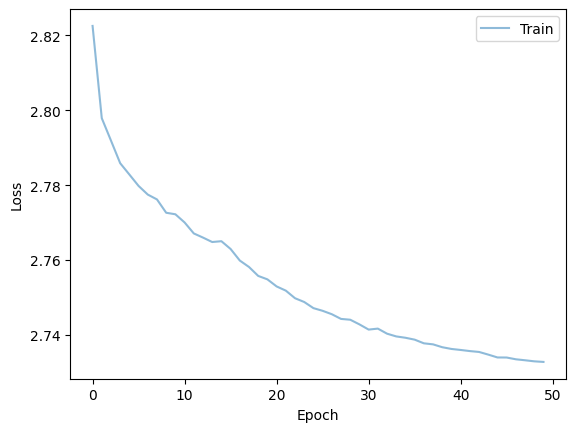

In [102]:
plt.plot(losses, alpha=0.5)
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [103]:
# Extract embeddings directly from the model
batter_embedding = model.batter_embedding.weight.data.numpy()
pitcher_embedding = model.pitcher_embedding.weight.data.numpy()

# Use LabelEncoder's classes_ to ensure the order of IDs matches the embedding indices
# original_batter_ids = label_encoder_batter.inverse_transform(label_encoder_batter.classes_)
# original_pitcher_ids = label_encoder_pitcher.inverse_transform(range(len(label_encoder_pitcher.classes_)))
original_batter_ids = label_encoder_batter.classes_
original_pitcher_ids = label_encoder_pitcher.classes_

# Create DataFrames for batter and pitcher embeddings
batter_df = pd.DataFrame(batter_embedding, index=original_batter_ids).reset_index()
pitcher_df = pd.DataFrame(pitcher_embedding, index=original_pitcher_ids).reset_index()

# Rename the index columns to 'batter' and 'pitcher'
batter_df.rename(columns={'index': 'batter'}, inplace=True)
pitcher_df.rename(columns={'index': 'pitcher'}, inplace=True)

# Rename embedding columns for clarity
batter_df.columns = ['batter'] + [f'embedding_{i}' for i in range(batter_df.shape[1] - 1)]
pitcher_df.columns = ['pitcher'] + [f'embedding_{i}' for i in range(pitcher_df.shape[1] - 1)]

# Count home runs % of total events for batters
home_runs = df[df['events'].str.contains('home_run')]['batter'].value_counts()
total_events = df['batter'].value_counts()

# Calculating the percentage
home_run_pct = (home_runs / total_events).fillna(0)  # Fill NaN with 0 for batters with no home runs
home_run_pct.name = 'home_run_pct'  # Naming the Series for clarity

# Merging the percentage back to batter_df
batter_df = batter_df.merge(home_run_pct, left_on='batter', right_index=True, how='left').fillna(0)

# Ensure the data types are correct, especially for the embeddings
batter_df = batter_df.astype({'batter': np.int64}, copy=False)
pitcher_df = pitcher_df.astype({'pitcher': np.int64}, copy=False)
for col in batter_df.columns[1:]:
    batter_df[col] = batter_df[col].astype(float)
for col in pitcher_df.columns[1:]:
    pitcher_df[col] = pitcher_df[col].astype(float)

# Save the embeddings with original IDs to CSV files
batter_df.to_csv('batter_embeddings_with_ids.csv', index=False)
pitcher_df.to_csv('pitcher_embeddings_with_ids.csv', index=False)

In [104]:
torch.save(model.state_dict(), 'baseball_model_bp2vec.pth')
batter_embedding = model.batter_embedding.weight.data.numpy()
pitcher_embedding = model.pitcher_embedding.weight.data.numpy()

In [105]:
# Correlate each embedding with the home run percentage
batter_corr = batter_df.iloc[:, 1:].corrwith(batter_df['home_run_pct'])

# Sort the correlations in descending order
batter_corr = batter_corr.abs().sort_values(ascending=False)

# Display the top 10 correlated embeddings
print(batter_corr)

home_run_pct     1.000000
embedding_59     0.546608
embedding_54     0.532452
embedding_2      0.523030
embedding_29     0.510595
                   ...   
embedding_119    0.006255
embedding_20     0.005009
embedding_19     0.002263
embedding_16     0.001762
embedding_58     0.000230
Length: 129, dtype: float64


In [106]:
# Calculate PCA for batters
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
batter_pca = pca.fit_transform(batter_embedding)

# Create a DataFrame for the PCA results
batter_pca_df = pd.DataFrame(batter_pca, columns=['PC1', 'PC2'])
batter_pca_df['batter'] = original_batter_ids
batter_pca_df['home_run_pct'] = batter_df["home_run_pct"]

# Correlate the PCA components with the home run percentage
pca_corr = batter_pca_df.iloc[:, :2].corrwith(batter_pca_df['home_run_pct'])

# Display the correlation results
print(pca_corr)
print(batter_pca_df.head())

PC1   -0.560260
PC2   -0.368538
dtype: float64
        PC1       PC2  batter  home_run_pct
0 -0.326974  5.293540  405395      0.043854
1  7.923483 -1.351942  408045      0.008969
2 -1.402086  1.492671  408234      0.030809
3  1.248140 -3.301199  425783      0.033762
4  0.410689  5.716651  425877      0.028133


<Axes: title={'center': 'Home Run % by Batter PCA Components'}, xlabel='PC1', ylabel='PC2'>

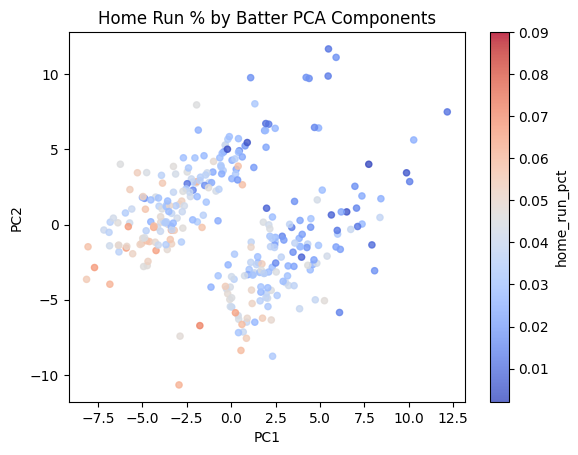

In [107]:
batter_pca_df.plot(kind='scatter', x='PC1', y='PC2', c='home_run_pct', cmap='coolwarm', alpha=0.8, vmax=0.09, title="Home Run % by Batter PCA Components")

<Axes: title={'center': 'Handedness by Batter PCA Components'}, xlabel='PC1', ylabel='PC2'>

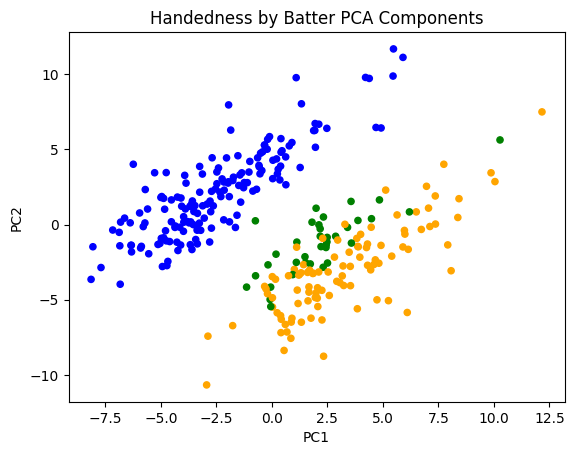

In [108]:
batter_pca_df["handedness"] = batter_pca_df["batter"].map(handedness_map)

hand_color_map = {"L": "orange", "R": "blue", "S": "green"}

batter_pca_df["hand_color"] = batter_pca_df["handedness"].map(hand_color_map)

batter_pca_df.plot(kind='scatter', x='PC1', y='PC2', color=batter_pca_df["hand_color"], title="Handedness by Batter PCA Components")